# CA4 (Group 3)

### Decentralized Gradient Descent (Algo1 below)
In the preprocessing step we obtained the inputs from the MNIST data set with the following dimensions for training data set. The rows of $X$ are 28x28 matrix (image) values with rows concatenated to form row of size 784. 

1. $X$ is ndarray with dimension 60000x784
2. $Y$ is ndarray with dimension 60000x1
3. $\mathbf{w}$ is ndarray with dimension 784x1

For the logistic rigression (without regularizer), the gradient is computed as follows:
\begin{equation}
\text{gradient} = -2X^T(Y-X\mathbf{w}).
\end{equation}

We have used backtracking line search for finding the step size ($2.38$x$10^{-7}$). By uing this step size, we found the norm of the gradient reduces monotonically. However, the convergence of GD is very slow, taking hours for the norm of the gradient to reduce to zero (theoretical stopping conditoin). Therefore, we terminate the training (Algo1 below) after a specified number of iterations. 



In [182]:
import pandas as pd
import numpy as np
import math
import time


In [88]:
#Read the data and divide it into 10 data sets
df = pd.read_csv('mnist_train.csv',index_col=False,header=None)

N = 60000 #Total numer of data samples
m = 10 #Number of workers
#Number of data
numSamples = N//m
YData = df.values[:,0].astype('float32')
YData = YData.reshape([N,1])
XData = df.values[:,1:785].astype('float32')
data = {}
X = {}
Y = {}
Z = {}
for idx in range(m):
    data[idx] = df.values[idx*numSamples:(idx+1)*numSamples].astype('float32')
    #data[idx] = data[idx].reset_index(drop=True)
    Y[idx] = data[idx][:,0] #labels
    Y[idx] = Y[idx].reshape([numSamples,1])
    X[idx] = data[idx][:,1:785]
    Z[idx] = -2*X[idx].T
    #print(data[idx].shape)

In [104]:
#Read the test data 
df_test = pd.read_csv('mnist_test.csv',index_col=False,header=None)

M = 10000 #Number of test samples
YTestData = df_test.values[:,0].astype('float32')
YTestData = YTestData.reshape([M,1])
XTestData = df_test.values[:,1:785].astype('float32')


In [ ]:
#Dimension of X is (N/m)x784, Y is (N/m)x1, and w is 784x1

#Log. Reg. Loss
def reg_loss(w):
    a = YTestData - XTestData.dot(w)
    return 1./M*(a.T @ a)

#This function is used to find an appropriate learning rate (step size)
def backtracking_line_search(grad,w):
    alpha = 0.2
    beta = 0.5
    t = 1
    while 1:
        z = w - t*grad
        if (np.linalg.norm(YData - XData.dot(z)) ** 2 \
            >= np.linalg.norm(YData - XData.dot(w)) ** 2 \
            - alpha*t*np.linalg.norm(grad) ** 2):
            t = t*beta
        else:
            break
    print('t',t)
    return t

#The dimensions are expressed with respect to train data
#X is ndarray with dimension 6000x784
#Y is ndarray with dimension 6000x1
#w is ndarray with dimension 784x1
def compute_gradient(X,Y,w):
    return -2*X.T.dot(Y - X.dot(w))

def Algo1(w,epsilon,p,sigma,Iterations):
    itr = 1
    maxIterations = 1000
    while 1:
        grad = np.zeros([784,1])
        for idx in range(m):
            #gradient of f: -2*X.T*(Y-X*w)
            #gf = -2*X[idx].T.dot(Y[idx] - (X[idx].dot(w)))
            gf = compute_gradient(X[idx],Y[idx],w)

            #Adding noise based on p and sigma (R = sigm^2)
            if np.random.random() < p:
                gf = gf + np.random.normal(0, sigma)
            
            grad = grad + gf
                    
        grad = grad/N
        #learn_rate = backtracking_line_search(grad,w)
        learn_rate = 2.38e-7 #This learning rate was inferred by using backtracking_line_search
        w = w - learn_rate*grad
        #print('grad norm:',np.linalg.norm(grad))
        if p == 0:
            if np.linalg.norm(grad) < epsilon or itr > Iterations:
                print('grad norm:',np.linalg.norm(grad))
                print('grad abs max:',abs(grad).max())
                break
        else:
            if np.linalg.norm(grad) < 112630 or itr > maxIterations:
            #if reg_loss(w) < 211184 or itr > maxIterations:
                print('grad norm:',np.linalg.norm(grad))
                break
        print(itr)
        itr = itr + 1
    return w

#Initializing weights
w = np.genfromtxt('wRand.csv', delimiter=',')
w = w.reshape([784,1])
epsilon = 0.01
Iterations = 50
#w = np.zeros([784,1])
p = 0.4
sigma = 1e9
start = time.time() 
w = Algo1(w,epsilon,p,sigma,Iterations)  
end = time.time()
print('time=',end-start,' seconds')
#np.savetxt('w.csv',w,delimiter=',')

Loss = reg_loss(w)
print('Regression Loss:',Loss)

# Part A: Affect of $p$ and $R$ on Convergence
In order to illustrate the affect of $p$ and $R$ on the convergence rate, we first train the weights with no noise for 50 iterations. We compute norm of the gradient using this $\mathbf{w}$ and then find the number of iterations it takes to achieve the same norm value in the presence of noise. For different $R$ values, we vary $p$ and obtain the number of iterations as the minimum over multiple runs. Note number of iterations differ between runs for the same $p$ and $R$ values because of the random values generated in each run differ. 

Our choice of $R$ is infludence by the learning rate we use: $2.38$x$10^{-7}$ and the number of samples over which the gradient is averaged. If the standard deviation of the normal random variable used for adding the noise is smaller than $10^{9}$, no significant affect can be observed as it will be nullified when multiplying with learning rate and divided by the number of samples. Therefore, we choose the standard deviation of the order of $10^9$ and thus $R$ is of the order of $10^{18}$.

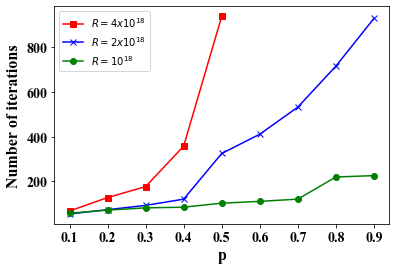

In [191]:
#Results
p = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#R = 4e18. For the case where the number of iterations exceed 1000, we use nan
Iterations1 = [68,128,177, 358, 938, nan, nan, nan, nan]

#R = 2e18
Iterations2 = [55, 74, 93, 121, 325, 411,  532, 715, 928]

#R = 1e18
Iterations3 = [58, 72, 82, 85, 103, 111, 121, 220,  226]

from pylab import *
%matplotlib inline

plt.rcParams["font.family"] = 'Times New Roman'
matplotlib.rcParams.update({'font.size': 10})
axes = plt.gca()
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.xlabel("p", fontsize=16)
plt.ylabel("Number of iterations", fontsize=16)
plt.plot(p,Iterations1,'-sr',label = '$R = 4x10^{18}$')
plt.plot(p,Iterations2,'-xb',label = '$R = 2x10^{18}$')
plt.plot(p,Iterations3,'-og',label = '$R = 10^{18}$')
legend()

From the above figure, we infer that, as $p$ and $R$ increases, the number of iterations required to achieve the same gradient norm in the noiseless case (with in 50 iterations), increases quickly.

# Part B - Decentralized subgradient method over Multihop Networks.

The two-star topology of network studied is shown in the picture below.

![](twostar.pdf)

## Transition Matrix Definition

The connectivity of the network can be described with the following (double stochastic) transition matrix.  

  
$$A = 
\begin{pmatrix}
5/6 & 0 & 0 & 0 & 1/6 & 0 & 0 & 0 & 0 & 0\\
0 & 5/6 & 0 & 0 & 1/6 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 5/6 & 0 & 1/6 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 5/6 & 1/6 & 0 & 0 & 0 & 0 & 0\\
1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6\\
0 & 0 & 0 & 0 & 0 & 1/6 & 5/6 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1/6 & 0 & 5/6 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1/6 & 0 & 0 & 5/6 & 0\\
0 & 0 & 0 & 0 & 0 & 1/6 & 0 & 0 & 0 & 5/6
\end{pmatrix}$$

In [ ]:
A = np.identity(10)*(5/6)
A[4,0:6]  = 1/6
A[5,5:10] = 1/6
A[0:6,4]  = 1/6
A[5:10,5] = 1/6
#print(A)

At each iteration, every agent $i$ must share their weights $w_i$ to reach a consensus among neighbors. In this step, with probability p, each node adds noise with variance R to their weight before sharing. The consensus is then calculated over the noisy weights. After this, the second step is for each agent to compute their subgradient using the consensus weights, and then update their weights to be used in the following iteration.

### Step 1: Consensus 

$\bar{w}_{i,k} = \sum_{i \in N_i}^{} a_{i,j}w_{j,k}$

### Step 2: Subgradient descent

$w_{i,k+1} = \bar{w}_{i,k}-\alpha_kg_i(\bar{w}_{i,k})$

In [ ]:
def addNoiseB(w,p,R):
    Q, N = w.shape
    w_noise = np.zeros((Q,N))
    for i in range(N):
        if np.random.random() < p:
            w_noise[:,i] = w[:,i] + np.random.normal(0, math.sqrt(R))
        else:
            w_noise[:,i] = w[:,i]
    return w_noise

def DSGD(X,Y,alpha,w,A,p,R,num_iter):
    Q,N     =  w.shape
    w_prev  =  w
    w_noise =  np.zeros((Q, N))
    w_      =  np.zeros((Q, N))
    grad    =  np.zeros((Q, N))
    
    for i_iter in range(num_iter):
        
        #Step 1: consensus
        w_noise = addNoiseB(w_prev,p,R)
        w_ = w_noise.dot(A)

        #Step 2: each agent computes its subgradient descend
        for n in range(N):
            aux = w_[:,n]
            var = compute_gradient(X[n],Y[n],aux.reshape((784,1)))
            if n == 1:
                print(np.linalg.norm(var))
            grad[:,n] = var.reshape((784,))
        w_prev = w_ - alpha*grad
    
    return w_prev   

# Part C - Critical Nodes

In the network studied in Part A, the most important node to protect is the master node since it is a single point of failure. The other two nodes could be selected randomly among the workers or considering different criteria such as the weights of each node.

Similarly, in the case of the two-star topology of Part B, nodes 5 and 6 are the most critical nodes to protect since they connect the two stars. The third node can be selected randomly, based on which star it belongs to, based on weights, or any other criteria.